In [19]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

usedu_df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [3]:
# using pandas interpolation function to fill missing values
fill_cols = usedu_df.columns[3:]
states = usedu_df['STATE'].unique()

# save empty enteries stats
before_inter = (usedu_df.isnull().sum()/usedu_df.shape[0]*100).values

for state in states:
    usedu_df.loc[usedu_df['STATE'] == state, fill_cols] = usedu_df.loc[usedu_df['STATE'] == state, fill_cols].interpolate()

# save empty entries stats after interpolation
after_inter = (usedu_df.isnull().sum()/usedu_df.shape[0]*100).values

# remaining missing values will be dropped
usedu_df.dropna(inplace=True)

# save empty entries stats after dropping na's
after_drop = (usedu_df.isnull().sum()/usedu_df.shape[0]*100).values

# print percent of empty cells before and after imputation
impute_ind = (usedu_df.isnull().sum()/usedu_df.shape[0]*100).index
print('{0:<30} {1:<12.3} {2:<12.3} {3:<12.3}'.format('', 'before', 'after interpolation', "after dropping na's")) 
for row in zip(impute_ind, before_inter, after_inter, after_drop):
    print('{0:<30} {1:<12.3} {2:<12.3} {3:<12.3}'.format(*row))

                               bef          aft          aft         
PRIMARY_KEY                    0.0          0.0          0.0         
STATE                          0.0          0.0          0.0         
YEAR                           0.0          0.0          0.0         
ENROLL                         17.6         14.1         0.0         
TOTAL_REVENUE                  14.2         10.8         0.0         
FEDERAL_REVENUE                14.2         10.8         0.0         
STATE_REVENUE                  14.2         10.8         0.0         
LOCAL_REVENUE                  14.2         10.8         0.0         
TOTAL_EXPENDITURE              14.2         10.8         0.0         
INSTRUCTION_EXPENDITURE        14.2         10.8         0.0         
SUPPORT_SERVICES_EXPENDITURE   14.2         10.8         0.0         
OTHER_EXPENDITURE              17.6         14.1         0.0         
CAPITAL_OUTLAY_EXPENDITURE     14.2         10.8         0.0         
GRADES_PK_G         

In [4]:
usedu_df.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
54,1993_ARIZONA,ARIZONA,1993,676297.0,3427976.0,318465.0,1415407.0,1694104.0,3623946.0,1578889.0,...,57701.0,53500.0,37614.0,461398.0,182737.0,647299.0,215.834434,265.993417,206.291984,262.448330
55,1993_ARKANSAS,ARKANSAS,1993,311432.0,1346909.0,128196.0,771079.0,447634.0,1376067.0,782791.0,...,34255.0,36471.0,27169.0,280280.0,125801.0,407329.0,211.616130,257.647254,208.685273,266.423396
57,1993_COLORADO,COLORADO,1993,539538.0,3058326.0,147793.0,1242337.0,1668196.0,3028305.0,1537714.0,...,50807.0,47665.0,34770.0,403871.0,164260.0,575380.0,222.219036,273.200878,215.523979,266.856804
58,1993_CONNECTICUT,CONNECTICUT,1993,471918.0,4064158.0,149204.0,1433539.0,2481415.0,4079943.0,2302852.0,...,39093.0,34662.0,27979.0,310022.0,127655.0,443893.0,228.105503,275.202320,224.712775,264.457874
59,1993_DELAWARE,DELAWARE,1993,104355.0,683954.0,44497.0,443250.0,196207.0,694534.0,394680.0,...,8285.0,8265.0,5882.0,67899.0,28930.0,97394.0,217.181255,263.834857,207.792430,262.255809


# 1. Create a new score variable from the weighted averages of all score variables in the datasets

In [5]:
# calculate math & reading weighted means

usedu_df['AVG_ALL_ALL_SCORE'] = ((usedu_df.AVG_MATH_4_SCORE + usedu_df.AVG_READING_4_SCORE) * usedu_df.GRADES_4_G + (usedu_df.AVG_MATH_8_SCORE + usedu_df.AVG_READING_8_SCORE) * usedu_df.GRADES_8_G)/((usedu_df.GRADES_4_G + usedu_df.GRADES_8_G)*2) 
usedu_df.iloc[:,-5:].describe()

,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,AVG_ALL_ALL_SCORE
count,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000
mean,235.269162,278.747113,219.099817,263.615681,249.206636
std,9.632646,9.912572,7.804302,5.768169,7.218087
min,187.134670,232.831510,179.324956,236.379102,210.794614
25%,230.660761,273.383577,214.943439,259.956991,245.691545
50%,237.041971,280.862695,220.962973,264.517851,250.517903
75%,241.940254,285.257700,224.164324,267.663197,253.886815
max,253.420961,300.568235,236.773867,280.499130,264.696429


# 2. What are the correlations between this newly created score variable and the expenditure types? Which 1 of the expenditure types is more correlated than the others?

In [17]:
# correlation matrix 
exp_cols = [col for col in usedu_df.columns if 'EXPENDITURE' in col]
exp_cols.append('AVG_ALL_ALL_SCORE')
usedu_df[exp_cols].corr()

,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,AVG_ALL_ALL_SCORE
TOTAL_EXPENDITURE,1.000000,0.990829,0.993175,0.946483,0.928576,0.093020
INSTRUCTION_EXPENDITURE,0.990829,1.000000,0.975867,0.907235,0.889763,0.105787
SUPPORT_SERVICES_EXPENDITURE,0.993175,0.975867,1.000000,0.953789,0.913680,0.098643
OTHER_EXPENDITURE,0.946483,0.907235,0.953789,1.000000,0.924197,0.027635
CAPITAL_OUTLAY_EXPENDITURE,0.928576,0.889763,0.913680,0.924197,1.000000,0.010670
AVG_ALL_ALL_SCORE,0.093020,0.105787,0.098643,0.027635,0.010670,1.000000


Very weak correlation with all expenditure variables. Instruction expenditure is slightly more correlated.

# 3. Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component?

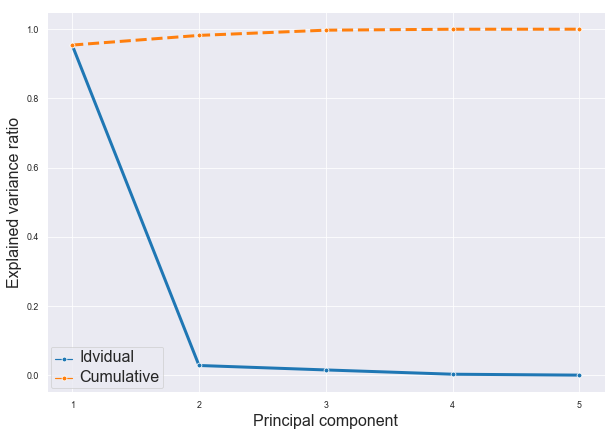

In [107]:
# applying PCA

# selecting only expenditure data
exp_cols = [col for col in usedu_df.columns if 'EXPENDITURE' in col]
data = usedu_df[exp_cols]

z_data = StandardScaler().fit_transform(data)
pca_trafo = PCA().fit(z_data)

plt.figure(figsize = (10,7))
g = sns.lineplot(y=pca_trafo.explained_variance_ratio_, x=list(range(1,6)), marker="o", label='Idvidual')
sns.lineplot(y=pca_trafo.explained_variance_ratio_.cumsum(), x=list(range(1,6)), marker="o", label='Cumulative')
sns.set_style('darkgrid')
sns.set_context( rc={'lines.markersize': 10}) # override marker size
plt.setp(g.lines,linewidth=3) # for line width
g.lines[1].set_linestyle("--") # for line style
plt.setp(g.get_legend().get_texts(), fontsize='16') # for legend text
plt.xlabel('Principal component', fontsize='16') # x-axis label
plt.ylabel('Explained variance ratio', fontsize='16') # y-axis label
g.set(xticks=list(range(1,6)))
plt.show()

In [106]:
sns.plotting_context()

{'font.size': 9.600000000000001,
 'axes.labelsize': 9.600000000000001,
 'axes.titlesize': 9.600000000000001,
 'xtick.labelsize': 8.8,
 'ytick.labelsize': 8.8,
 'legend.fontsize': 8.8,
 'axes.linewidth': 1.0,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.2000000000000002,
 'lines.markersize': 4.800000000000001,
 'patch.linewidth': 0.8,
 'xtick.major.width': 1.0,
 'ytick.major.width': 1.0,
 'xtick.minor.width': 0.8,
 'ytick.minor.width': 0.8,
 'xtick.major.size': 4.800000000000001,
 'ytick.major.size': 4.800000000000001,
 'xtick.minor.size': 3.2,
 'ytick.minor.size': 3.2}